In [2]:
!pip install hdbscan

   ---------------------------------------- 0.0/811.2 kB ? eta -:--:--
   ---------------------------------------- 811.2/811.2 kB 8.7 MB/s eta 0:00:00


Merging on 'date' column...
Merged shape: (190, 83)
After dropping high-NaN columns: (190, 76)
Remaining NaNs after fill: 0


C:\Users\Marry\anaconda3\envs\Gold\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Marry\anaconda3\envs\Gold\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


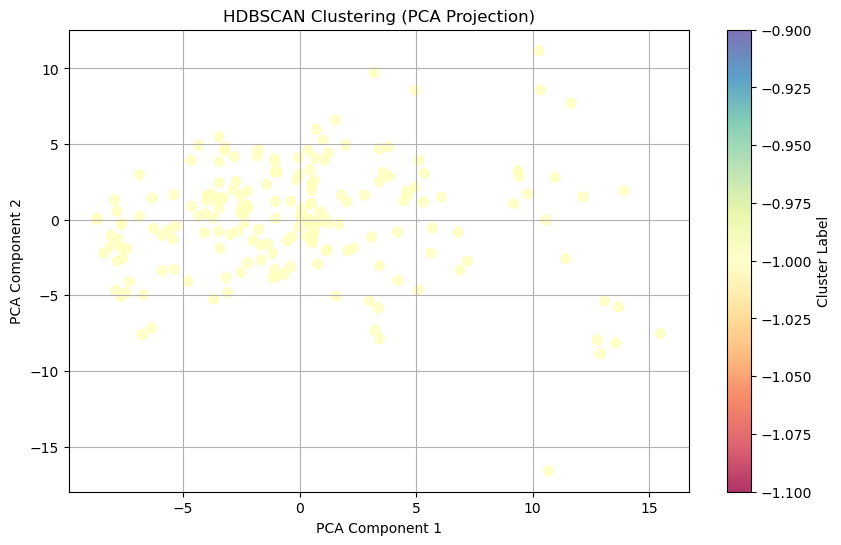

✅ Clustering complete. Results saved to 'merged_with_clusters.csv'.


In [1]:
# ===============================
# HDBSCAN Clustering Script
# ===============================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import hdbscan

# -------------------------------------
# Step 1: Load both CSV files
# -------------------------------------
df_static = pd.read_csv("static_features_merged.csv")
df_sr = pd.read_csv("support_resistance_features_enhanced.csv")

# -------------------------------------
# Step 2: Inspect date columns
# -------------------------------------
# Ensure 'date' is string and properly formatted
df_static['date'] = pd.to_datetime(df_static['date'], errors='coerce')
df_sr['date'] = pd.to_datetime(df_sr['date'], errors='coerce')

# Drop rows with missing dates
df_static = df_static.dropna(subset=['date'])
df_sr = df_sr.dropna(subset=['date'])

# -------------------------------------
# Step 3: Merge datasets on date
# -------------------------------------
print("Merging on 'date' column...")
df_merged = pd.merge(df_static, df_sr, on='date', how='inner')
print(f"Merged shape: {df_merged.shape}")

# -------------------------------------
# Step 4: Drop non-numeric & high-NaN columns
# -------------------------------------
non_numeric_cols = ['date', 
                    'broke_above_prev_high_any', 
                    'broke_below_prev_low_any',
                    'broke_above_zone_top_any',
                    'broke_below_zone_bottom_any',
                    'broke_above_prev_close_any',
                    'broke_below_prev_close_any']

df_numeric = df_merged.drop(columns=non_numeric_cols, errors='ignore')

# Drop columns with >50% missing values
thresh = 0.5
df_numeric = df_numeric.loc[:, df_numeric.isnull().mean() < (1 - thresh)]
print(f"After dropping high-NaN columns: {df_numeric.shape}")

# Fill remaining NaNs with column median
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))
print(f"Remaining NaNs after fill: {df_numeric.isna().sum().sum()}")

# -------------------------------------
# Step 5: Scale the Data
# -------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# -------------------------------------
# Step 6: Apply HDBSCAN
# -------------------------------------
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,
    min_samples=5,
    metric='euclidean',
    prediction_data=True
)

cluster_labels = clusterer.fit_predict(X_scaled)

# -------------------------------------
# Step 7: Attach cluster labels
# -------------------------------------
df_merged['cluster'] = cluster_labels
df_merged['cluster_prob'] = clusterer.probabilities_

# -------------------------------------
# Step 8: Visualize Clusters with PCA
# -------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=cluster_labels,
    cmap='Spectral',
    s=50,
    alpha=0.8
)
plt.colorbar(scatter, label='Cluster Label')
plt.title("HDBSCAN Clustering (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

# -------------------------------------
# Step 9: (Optional) Save results
# -------------------------------------
df_merged.to_csv("merged_with_clusters.csv", index=False)
print("✅ Clustering complete. Results saved to 'merged_with_clusters.csv'.")



In [3]:
df_merged['us_open_return'] = df_merged['last_close_x'] - df_merged['first_open_x']

In [4]:
df_merged['us_open_direction'] = np.where(df_merged['us_open_return'] > 0, 'Bullish', 'Bearish')

In [5]:
cluster_summary = df_merged.groupby(['cluster', 'us_open_direction']).size().unstack(fill_value=0)
cluster_summary['total'] = cluster_summary.sum(axis=1)
cluster_summary['bullish_ratio'] = cluster_summary.get('Bullish', 0) / cluster_summary['total']
cluster_summary['bearish_ratio'] = cluster_summary.get('Bearish', 0) / cluster_summary['total']

In [6]:
print(cluster_summary.sort_values('total', ascending=False))

us_open_direction  Bearish  Bullish  total  bullish_ratio  bearish_ratio
cluster                                                                 
-1                      90      100    190       0.526316       0.473684
